## Import necessary libraries

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

# Core PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler

# System and file handling
import os
import glob
from pathlib import Path
import random
import shutil

# Progress tracking and utilities
from tqdm import tqdm
import time
import copy
import warnings
warnings.filterwarnings('ignore')

# Image processing
from PIL import Image
import cv2

# Vision-specific imports
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.sampler import SequentialSampler

## Data Preparation

### Load metadata

In [85]:
data = '../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'

df = pd.read_csv(data)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [87]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [88]:
df['age'].value_counts()

age
45.0    1299
50.0    1187
55.0    1009
40.0     985
60.0     803
70.0     756
35.0     753
65.0     731
75.0     618
30.0     464
80.0     404
85.0     290
25.0     247
20.0     169
5.0       86
15.0      77
10.0      41
0.0       39
Name: count, dtype: int64

In [89]:
# Handle missing age values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')  
df['age'] = imputer.fit_transform(df[['age']]).ravel()

In [90]:
df.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

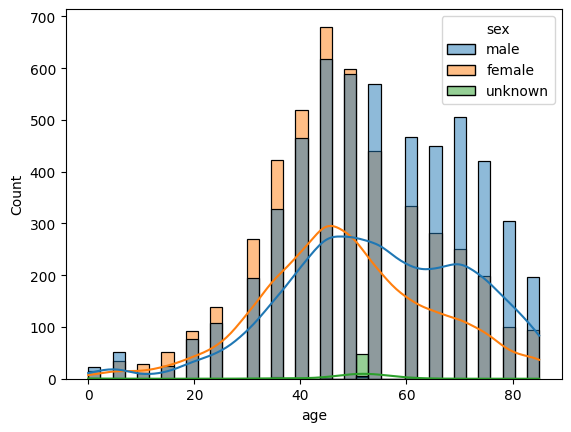

In [91]:
# Plot Histogram
sns.histplot(data = df, x = "age", kde = True, hue = "sex");

In [92]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [93]:
dx_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

df['diagnosis'] = df['dx'].map(dx_dict.get) 

In [94]:
df['diagnosis'].value_counts()

diagnosis
Melanocytic nevi                 6705
Melanoma                         1113
Benign keratosis-like lesions    1099
Basal cell carcinoma              514
Actinic keratoses                 327
Vascular lesions                  142
Dermatofibroma                    115
Name: count, dtype: int64

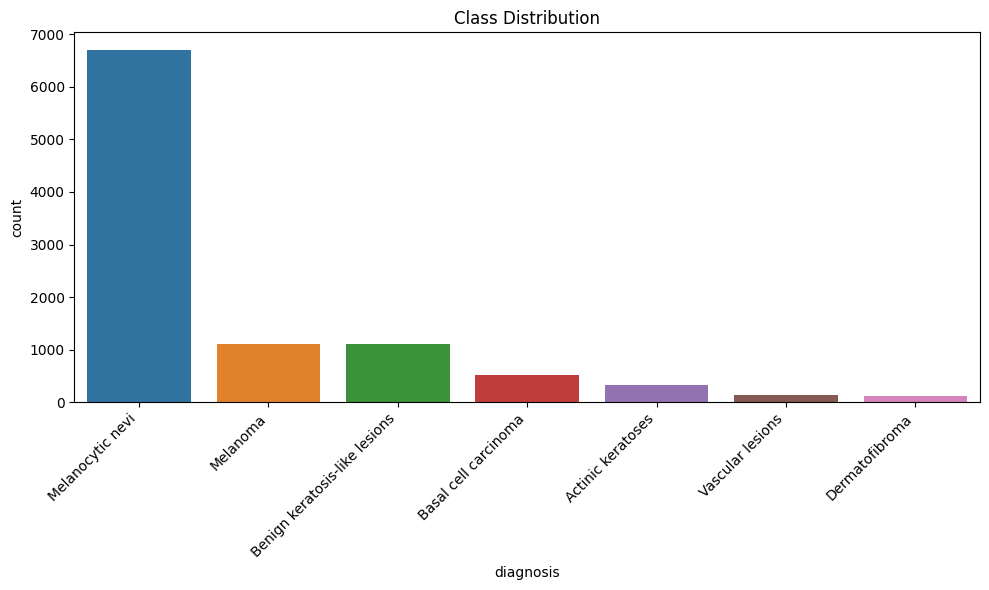

In [95]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='diagnosis', order=df['diagnosis'].value_counts().index)
plt.title('Class Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

In [96]:
# Create numerical labels
label_dict = {v: k for k, v in enumerate(dx_dict.keys())}
df['label'] = df['dx'].map(label_dict)

df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,diagnosis,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign keratosis-like lesions,2


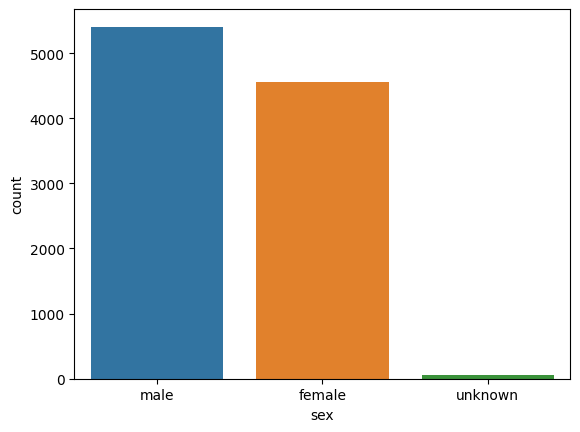

In [97]:
# count plot on sex
sns.countplot(x ='sex', data = df)
plt.show();

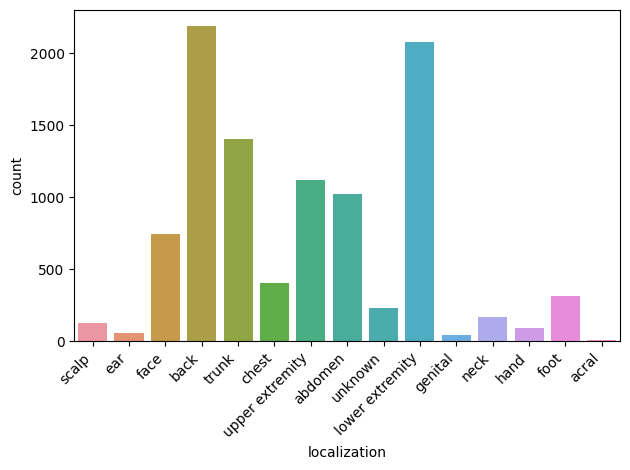

In [98]:
# count plot on localization
sns.countplot(x ='localization', data = df)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

### Map Image paths

In [99]:
# Set image directory paths
image_dir = '../input/skin-cancer-mnist-ham10000'
part1_path = os.path.join(image_dir, 'ham10000_images_part_1')
part2_path = os.path.join(image_dir, 'ham10000_images_part_2')

In [100]:
image_paths = glob.glob(os.path.join(part1_path, "*.jpg")) + glob.glob(os.path.join(part2_path, "*.jpg"))
path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in image_paths}
df["path"] = df["image_id"].map(path_dict)

### Handle class imbalance

In [101]:
classes = sorted(df['dx'].unique())
class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=classes, 
    y=df['dx']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [102]:
class SkinCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
        # Define all possible categories for metadata
        self.sex_categories = ['male', 'female', 'unknown']
        self.localization_categories = sorted(df['localization'].unique().tolist())
        
    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.df.iloc[idx]["path"]
        image = Image.open(img_path).convert('RGB')
        
        # Load and preprocess metadata
        meta = self.df.iloc[idx]
        age = meta["age"] / 100.0  # Normalize age (0-100 range)
        
        # Encode sex (one-hot)
        sex = meta["sex"].lower()  # Ensure case consistency
        sex_encoded = [1 if sex == cat else 0 for cat in self.sex_categories]
        
        # Encode localization (one-hot)
        loc = meta["localization"]
        loc_encoded = [1 if loc == cat else 0 for cat in self.localization_categories]
        
        # Combine all metadata features
        meta_tensor = torch.tensor([age] + sex_encoded + loc_encoded, dtype=torch.float32)
        
        # Label
        label = self.df.iloc[idx]["label"]
        
        # Apply image transforms
        if self.transform:
            image = self.transform(image)
            
        return image, meta_tensor, label

### Data Augmentation & Transforms

In [103]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Data Splitting

In [104]:
# Train-Validation-Test Split
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["dx"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["dx"])

print(f"\nDataset Split:")
print(f"Train: {len(train_df)} ({len(train_df)/len(df):.1%})")
print(f"Validation: {len(val_df)} ({len(val_df)/len(df):.1%})")
print(f"Test: {len(test_df)} ({len(test_df)/len(df):.1%})")


Dataset Split:
Train: 7010 (70.0%)
Validation: 1502 (15.0%)
Test: 1503 (15.0%)


### Hybrid Model Architecture

#### Fuse image CNN with metadata

In [105]:
class HybridModel(nn.Module):
    def __init__(self, num_classes, meta_size):
        super().__init__()
        # Image feature extractor (pretrained ResNet)
        self.cnn = models.resnet50(pretrained=True)
        in_features = self.cnn.fc.in_features
        self.cnn.fc = nn.Identity()  # Remove final layer
        
        # Metadata branch
        self.meta_fc = nn.Sequential(
            nn.Linear(meta_size, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Combined classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, img, meta):
        img_features = self.cnn(img)
        meta_features = self.meta_fc(meta)
        combined = torch.cat((img_features, meta_features), dim=1)
        return self.classifier(combined)

### Training setup

In [106]:
# Create datasets
train_dataset = SkinCancerDataset(train_df, transform=train_transform)
val_dataset = SkinCancerDataset(val_df, transform=val_transform)

In [107]:
# Create sample weights for training
train_labels = train_df["label"].values
train_indices = torch.tensor(train_labels, dtype=torch.long)
train_sample_weights = class_weights[train_indices]

In [108]:
# Create samplers
train_sampler = WeightedRandomSampler(
    train_sample_weights,
    num_samples=len(train_df),
    replacement=True
)

val_sampler = SequentialSampler(val_dataset)  # No weighting for validation

In [109]:
# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=train_sampler,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    sampler=val_sampler
)

### Define device

In [110]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [111]:
# Initialize model with CORRECT meta_size
localization_categories = sorted(df['localization'].unique().tolist())
meta_size = 1 + len(['male','female','unknown']) + len(localization_categories)

model = HybridModel(num_classes=len(classes), meta_size=meta_size)
model = model.to(device)

# Use weighted loss (move weights to device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

In [112]:
# Optimizer and Scheduler Setup
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.5, 
    patience=3, 
    verbose=True
)

# Early Stopping Setup
best_val_acc = 0.0
patience_counter = 0
early_stop_patience = 7  # Stop if no improvement for 7 epochs

# Training Parameters
num_epochs = 50
log_interval = 50  # Log every 50 batches

# Training Loop with Validation
for epoch in range(num_epochs):
    # TRAINING PHASE
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (images, meta, labels) in enumerate(pbar):
        # Move data to device
        images = images.to(device)
        meta = meta.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images, meta)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Update progress bar
        pbar.set_postfix({
            'loss': running_loss/(i+1), 
            'acc': 100.*correct/total
        })
    
    train_acc = 100. * correct / total
    train_loss = running_loss / len(train_loader)
    
    # VALIDATION PHASE
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, meta, labels in val_loader:
            images = images.to(device)
            meta = meta.to(device)
            labels = labels.to(device)
            
            outputs = model(images, meta)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    val_loss /= len(val_loader)
    
    print(f"Epoch {epoch+1}: "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")
    
    # Update scheduler
    scheduler.step(val_acc)
    
    # EARLY STOPPING CHECK
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_model.pth')
        print(f"Saved new best model with val acc: {val_acc:.2f}%")
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter}/{early_stop_patience} epochs")
        
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered!")
            break

Epoch 1/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.492, acc=81.4]


Epoch 1: Train Loss: 0.4919, Acc: 81.44% | Val Loss: 0.5503, Acc: 70.84%
Saved new best model with val acc: 70.84%


Epoch 2/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.297, acc=85.7]


Epoch 2: Train Loss: 0.2972, Acc: 85.74% | Val Loss: 0.7250, Acc: 67.11%
No improvement for 1/7 epochs


Epoch 3/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.249, acc=86.8]


Epoch 3: Train Loss: 0.2487, Acc: 86.83% | Val Loss: 0.4489, Acc: 76.17%
Saved new best model with val acc: 76.17%


Epoch 4/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.218, acc=88.2]


Epoch 4: Train Loss: 0.2179, Acc: 88.23% | Val Loss: 0.4708, Acc: 76.36%
Saved new best model with val acc: 76.36%


Epoch 5/50: 100%|██████████| 219/219 [01:48<00:00,  2.03it/s, loss=0.211, acc=88.4]


Epoch 5: Train Loss: 0.2113, Acc: 88.41% | Val Loss: 0.4455, Acc: 75.57%
No improvement for 1/7 epochs


Epoch 6/50: 100%|██████████| 219/219 [01:49<00:00,  2.01it/s, loss=0.18, acc=89.1] 


Epoch 6: Train Loss: 0.1799, Acc: 89.07% | Val Loss: 0.4481, Acc: 76.50%
Saved new best model with val acc: 76.50%


Epoch 7/50: 100%|██████████| 219/219 [01:48<00:00,  2.02it/s, loss=0.177, acc=89.4]


Epoch 7: Train Loss: 0.1768, Acc: 89.37% | Val Loss: 0.4180, Acc: 75.90%
No improvement for 1/7 epochs


Epoch 8/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.16, acc=90.2] 


Epoch 8: Train Loss: 0.1597, Acc: 90.17% | Val Loss: 0.4573, Acc: 76.63%
Saved new best model with val acc: 76.63%


Epoch 9/50: 100%|██████████| 219/219 [01:48<00:00,  2.02it/s, loss=0.151, acc=90.9]


Epoch 9: Train Loss: 0.1507, Acc: 90.88% | Val Loss: 0.4173, Acc: 77.43%
Saved new best model with val acc: 77.43%


Epoch 10/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.154, acc=90.5]


Epoch 10: Train Loss: 0.1541, Acc: 90.51% | Val Loss: 0.4527, Acc: 76.90%
No improvement for 1/7 epochs


Epoch 11/50: 100%|██████████| 219/219 [01:48<00:00,  2.02it/s, loss=0.134, acc=91.4]


Epoch 11: Train Loss: 0.1336, Acc: 91.40% | Val Loss: 0.4044, Acc: 77.23%
No improvement for 2/7 epochs


Epoch 12/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.135, acc=90.9]


Epoch 12: Train Loss: 0.1355, Acc: 90.87% | Val Loss: 0.4274, Acc: 78.23%
Saved new best model with val acc: 78.23%


Epoch 13/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.124, acc=91.4]


Epoch 13: Train Loss: 0.1243, Acc: 91.38% | Val Loss: 0.3866, Acc: 79.36%
Saved new best model with val acc: 79.36%


Epoch 14/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.136, acc=91.4]


Epoch 14: Train Loss: 0.1364, Acc: 91.44% | Val Loss: 0.5230, Acc: 78.36%
No improvement for 1/7 epochs


Epoch 15/50: 100%|██████████| 219/219 [01:48<00:00,  2.02it/s, loss=0.12, acc=92.1] 


Epoch 15: Train Loss: 0.1197, Acc: 92.09% | Val Loss: 0.4843, Acc: 77.36%
No improvement for 2/7 epochs


Epoch 16/50: 100%|██████████| 219/219 [01:49<00:00,  2.00it/s, loss=0.138, acc=92]  


Epoch 16: Train Loss: 0.1384, Acc: 91.98% | Val Loss: 0.4183, Acc: 78.23%
No improvement for 3/7 epochs


Epoch 17/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.117, acc=92.1]


Epoch 17: Train Loss: 0.1173, Acc: 92.14% | Val Loss: 0.3709, Acc: 79.03%
No improvement for 4/7 epochs


Epoch 18/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.089, acc=93.8] 


Epoch 18: Train Loss: 0.0890, Acc: 93.76% | Val Loss: 0.4082, Acc: 81.29%
Saved new best model with val acc: 81.29%


Epoch 19/50: 100%|██████████| 219/219 [01:46<00:00,  2.05it/s, loss=0.072, acc=94.7] 


Epoch 19: Train Loss: 0.0720, Acc: 94.66% | Val Loss: 0.4180, Acc: 81.03%
No improvement for 1/7 epochs


Epoch 20/50: 100%|██████████| 219/219 [01:46<00:00,  2.05it/s, loss=0.0703, acc=94.5]


Epoch 20: Train Loss: 0.0703, Acc: 94.51% | Val Loss: 0.3632, Acc: 82.62%
Saved new best model with val acc: 82.62%


Epoch 21/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.0671, acc=95.1]


Epoch 21: Train Loss: 0.0671, Acc: 95.06% | Val Loss: 0.3694, Acc: 81.89%
No improvement for 1/7 epochs


Epoch 22/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.063, acc=95.3] 


Epoch 22: Train Loss: 0.0630, Acc: 95.31% | Val Loss: 0.3426, Acc: 83.16%
Saved new best model with val acc: 83.16%


Epoch 23/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.0535, acc=95.8]


Epoch 23: Train Loss: 0.0535, Acc: 95.85% | Val Loss: 0.4444, Acc: 84.55%
Saved new best model with val acc: 84.55%


Epoch 24/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.0544, acc=95.7]


Epoch 24: Train Loss: 0.0544, Acc: 95.72% | Val Loss: 0.3649, Acc: 84.89%
Saved new best model with val acc: 84.89%


Epoch 25/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.0568, acc=95.7]


Epoch 25: Train Loss: 0.0568, Acc: 95.69% | Val Loss: 0.3665, Acc: 83.75%
No improvement for 1/7 epochs


Epoch 26/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.0487, acc=96.5]


Epoch 26: Train Loss: 0.0487, Acc: 96.48% | Val Loss: 0.3562, Acc: 84.75%
No improvement for 2/7 epochs


Epoch 27/50: 100%|██████████| 219/219 [01:48<00:00,  2.03it/s, loss=0.0514, acc=96.1]


Epoch 27: Train Loss: 0.0514, Acc: 96.08% | Val Loss: 0.4274, Acc: 84.29%
No improvement for 3/7 epochs


Epoch 28/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.0546, acc=96.1]


Epoch 28: Train Loss: 0.0546, Acc: 96.12% | Val Loss: 0.3213, Acc: 83.82%
No improvement for 4/7 epochs


Epoch 29/50: 100%|██████████| 219/219 [01:49<00:00,  2.00it/s, loss=0.0415, acc=96.9]


Epoch 29: Train Loss: 0.0415, Acc: 96.86% | Val Loss: 0.3440, Acc: 85.75%
Saved new best model with val acc: 85.75%


Epoch 30/50: 100%|██████████| 219/219 [01:48<00:00,  2.02it/s, loss=0.035, acc=97.1] 


Epoch 30: Train Loss: 0.0350, Acc: 97.10% | Val Loss: 0.3451, Acc: 86.02%
Saved new best model with val acc: 86.02%


Epoch 31/50: 100%|██████████| 219/219 [01:46<00:00,  2.05it/s, loss=0.0368, acc=97.2]


Epoch 31: Train Loss: 0.0368, Acc: 97.23% | Val Loss: 0.3258, Acc: 85.82%
No improvement for 1/7 epochs


Epoch 32/50: 100%|██████████| 219/219 [01:46<00:00,  2.06it/s, loss=0.0352, acc=97.2]


Epoch 32: Train Loss: 0.0352, Acc: 97.19% | Val Loss: 0.3839, Acc: 85.95%
No improvement for 2/7 epochs


Epoch 33/50: 100%|██████████| 219/219 [01:48<00:00,  2.02it/s, loss=0.0329, acc=97.7]


Epoch 33: Train Loss: 0.0329, Acc: 97.69% | Val Loss: 0.3667, Acc: 85.89%
No improvement for 3/7 epochs


Epoch 34/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.0264, acc=97.8]


Epoch 34: Train Loss: 0.0264, Acc: 97.80% | Val Loss: 0.3689, Acc: 87.42%
Saved new best model with val acc: 87.42%


Epoch 35/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.0261, acc=97.8]


Epoch 35: Train Loss: 0.0261, Acc: 97.76% | Val Loss: 0.3818, Acc: 86.42%
No improvement for 1/7 epochs


Epoch 36/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.0285, acc=97.7]


Epoch 36: Train Loss: 0.0285, Acc: 97.67% | Val Loss: 0.3880, Acc: 86.28%
No improvement for 2/7 epochs


Epoch 37/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.0278, acc=97.6]


Epoch 37: Train Loss: 0.0278, Acc: 97.56% | Val Loss: 0.3777, Acc: 85.95%
No improvement for 3/7 epochs


Epoch 38/50: 100%|██████████| 219/219 [01:48<00:00,  2.01it/s, loss=0.0263, acc=97.8]


Epoch 38: Train Loss: 0.0263, Acc: 97.79% | Val Loss: 0.3797, Acc: 86.48%
No improvement for 4/7 epochs


Epoch 39/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.0193, acc=98.3]


Epoch 39: Train Loss: 0.0193, Acc: 98.26% | Val Loss: 0.3647, Acc: 86.75%
No improvement for 5/7 epochs


Epoch 40/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.018, acc=98.5] 


Epoch 40: Train Loss: 0.0180, Acc: 98.52% | Val Loss: 0.3803, Acc: 87.08%
No improvement for 6/7 epochs


Epoch 41/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.0201, acc=98.3]


Epoch 41: Train Loss: 0.0201, Acc: 98.33% | Val Loss: 0.3844, Acc: 87.48%
Saved new best model with val acc: 87.48%


Epoch 42/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.016, acc=98.4] 


Epoch 42: Train Loss: 0.0160, Acc: 98.44% | Val Loss: 0.3981, Acc: 86.68%
No improvement for 1/7 epochs


Epoch 43/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.0164, acc=98.6]


Epoch 43: Train Loss: 0.0164, Acc: 98.56% | Val Loss: 0.3784, Acc: 87.28%
No improvement for 2/7 epochs


Epoch 44/50: 100%|██████████| 219/219 [01:48<00:00,  2.03it/s, loss=0.0178, acc=98.6]


Epoch 44: Train Loss: 0.0178, Acc: 98.57% | Val Loss: 0.3758, Acc: 86.55%
No improvement for 3/7 epochs


Epoch 45/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.013, acc=98.9] 


Epoch 45: Train Loss: 0.0130, Acc: 98.90% | Val Loss: 0.3891, Acc: 87.62%
Saved new best model with val acc: 87.62%


Epoch 46/50: 100%|██████████| 219/219 [01:47<00:00,  2.05it/s, loss=0.0144, acc=98.9]


Epoch 46: Train Loss: 0.0144, Acc: 98.90% | Val Loss: 0.4177, Acc: 85.55%
No improvement for 1/7 epochs


Epoch 47/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.0124, acc=98.8]


Epoch 47: Train Loss: 0.0124, Acc: 98.76% | Val Loss: 0.4188, Acc: 86.88%
No improvement for 2/7 epochs


Epoch 48/50: 100%|██████████| 219/219 [01:47<00:00,  2.03it/s, loss=0.0136, acc=98.8] 


Epoch 48: Train Loss: 0.0136, Acc: 98.82% | Val Loss: 0.4309, Acc: 87.28%
No improvement for 3/7 epochs


Epoch 49/50: 100%|██████████| 219/219 [01:47<00:00,  2.04it/s, loss=0.0135, acc=98.6]


Epoch 49: Train Loss: 0.0135, Acc: 98.64% | Val Loss: 0.3768, Acc: 87.75%
Saved new best model with val acc: 87.75%


Epoch 50/50: 100%|██████████| 219/219 [01:49<00:00,  2.01it/s, loss=0.0128, acc=98.8]


Epoch 50: Train Loss: 0.0128, Acc: 98.83% | Val Loss: 0.3937, Acc: 87.02%
No improvement for 1/7 epochs


In [113]:
# Load Best Model for Testing
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model with val acc: {checkpoint['val_acc']:.2f}%")

Loaded best model with val acc: 87.75%


In [114]:
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, meta, labels in dataloader:
            images = images.to(device)
            meta = meta.to(device)
            labels = labels.to(device)
            
            outputs = model(images, meta)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=classes)
    
    print(f"Test Accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(cr)
    
    # Plot confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, 
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    return acc

Test Accuracy: 0.8782

Classification Report:
              precision    recall  f1-score   support

       akiec       0.92      0.96      0.94      1006
         bcc       0.72      0.70      0.71       167
         bkl       0.83      0.74      0.78       165
          df       0.80      0.90      0.85        77
         mel       0.77      0.61      0.68        49
          nv       0.00      0.00      0.00        22
        vasc       0.74      0.82      0.78        17

    accuracy                           0.88      1503
   macro avg       0.68      0.68      0.68      1503
weighted avg       0.86      0.88      0.87      1503



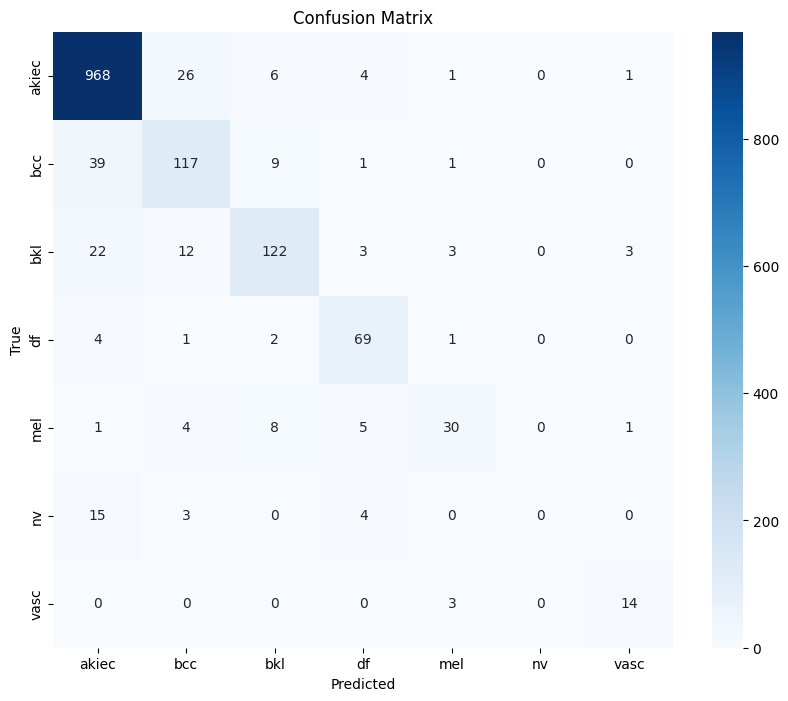

In [115]:
# Create test dataset and loader
test_dataset = SkinCancerDataset(test_df, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate
test_acc = evaluate(model, test_loader)